### Predict lung masks and Covid vs non-Covid classification for new patient CXR using Module 1 trained on the V7 lung segmentation database, and Module 2 trained on the HFHS dataset   



In [1]:
# In[1]:

import os, sys, shutil
from os import listdir
from os.path import isfile, join
import random
import numpy as np
import cv2
import pandas as pd
import json
import datetime
import csv, h5py


In [2]:
# In[2]:

from MODULES_1.Generators import train_generator_1, val_generator_1, test_generator_1
from MODULES_1.Generators import train_generator_2, val_generator_2, test_generator_2
from MODULES_1.Networks import ResNet_Atrous, Dense_ResNet_Atrous
from MODULES_1.Losses import dice_coeff
from MODULES_1.Losses import tani_loss, tani_coeff, weighted_tani_coeff
from MODULES_1.Losses import weighted_tani_loss, other_metrics
from MODULES_1.Constants import _Params, _Paths
from MODULES_1.Utils import get_class_threshold, get_model_memory_usage
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, model_from_json, load_model, clone_model 
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
import datetime

# automatic reload of external definitions if changed during testing
%load_ext autoreload
%autoreload 2


In [3]:
# In[3]:

# ### CONSTANTS

HEIGHT, WIDTH, CHANNELS, IMG_COLOR_MODE, MSK_COLOR_MODE, NUM_CLASS, \
    KS1, KS2, KS3, DL1, DL2, DL3, NF, NFL, NR1, NR2, DIL_MODE, W_MODE, LS, \
    TRAIN_SIZE, VAL_SIZE, TEST_SIZE, DR1, DR2, CLASSES, IMG_CLASS = _Params()

TRAIN_IMG_PATH, TRAIN_MSK_PATH, TRAIN_MSK_CLASS, VAL_IMG_PATH, \
    VAL_MSK_PATH, VAL_MSK_CLASS, TEST_IMG_PATH, TEST_MSK_PATH, TEST_MSK_CLASS = _Paths()


In [4]:
# In[4]: 

# ### LOAD LUNG SEGMENTATION MODEL FROM PREVIOUS RUN AND COMPILE

model_selection = 'model_' + str(NF) + 'F_' + str(NR1) + 'R1_' + str(NR2) + 'R2'
model_number = '2020-10-16_21_26' # model number from an earlier run
filepath = 'models/' + model_selection + '_' + model_number + '_all' + '.h5'

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = load_model(filepath, compile=False)     
    model.compile(optimizer=Adam(), loss=weighted_tani_loss, metrics=[tani_coeff]) 
    

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensor

In [5]:
print(model_selection,model_number)

model_16F_5R1_0R2 2020-10-16_21_26


In [6]:
# In[5]

# ### PREDICT MASKS - PLOTS

print(CLASSES)

# Source directory containing COVID patients lung CXR's
source_resized_img_path = 'new_patient_cxr/image_resized_equalized/'

# Target directories containing masks predicted for the CXR images in the source directory:
# For V7 database
target_resized_msk_path_binary = 'new_patient_cxr/mask_binary/'
target_resized_msk_path_float = 'new_patient_cxr/mask_float/'
target_img_mask_path = 'new_patient_cxr/image_mask/'

# Remove existing target directories and all their content if already present
pwd = os.getcwd()
root_dir = '/wsu/home/aa/aa14/aa1426/Documents/JENA/MYOTUBES_SEGMENTATION/CXR-Net/run_CXR-Net/'
if root_dir == pwd:
    for root, dirs, files in os.walk(target_resized_msk_path_binary):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d))
    for root, dirs, files in os.walk(target_resized_msk_path_float):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d)) 
    for root, dirs, files in os.walk(target_img_mask_path):
        for f in files:
            os.unlink(os.path.join(root, f))
        for d in dirs:
            shutil.rmtree(os.path.join(root, d)) 
            
# Create directories that will store the masks on which to train the classification network
if not os.path.exists(target_resized_msk_path_binary):
    os.makedirs(target_resized_msk_path_binary)
    
if not os.path.exists(target_resized_msk_path_float):
    os.makedirs(target_resized_msk_path_float) 
    
if not os.path.exists(target_img_mask_path):
    os.makedirs(target_img_mask_path)

# get CXR image names from source directory                
source_img_names = [f for f in listdir(source_resized_img_path) if isfile(join(source_resized_img_path, f))]

for name in source_img_names:
    input_img = cv2.imread(source_resized_img_path + name, cv2.IMREAD_GRAYSCALE)
    scaled_img = input_img/255
    scaled_img = np.expand_dims(scaled_img,axis = [0,-1])
    mask = model(scaled_img).numpy()
    mask_float = np.squeeze(mask[0,:,:,0])    
    mask_binary = (mask_float > 0.5)*1
    
    mask_float *=255    
    mask_binary *=255
    cv2.imwrite(target_resized_msk_path_float + name, mask_float)
    cv2.imwrite(target_resized_msk_path_binary + name, mask_binary)
    
    fig = plt.figure(figsize=(20,10))
    fig.subplots_adjust(hspace=0.4, wspace=0.2)

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(np.squeeze(input_img), cmap="gray")
    ax = fig.add_subplot(1, 2, 2)
    ax.imshow(np.squeeze(mask_binary), cmap="gray")       

    plt.savefig(target_img_mask_path + name + '_img_and_pred_mask.png') 
    plt.close()
    

['lungs', 'non_lungs']


In [7]:
print(input_img.shape,mask.shape,mask_float.shape,mask_binary.shape)

(300, 340) (1, 300, 340, 2) (300, 340) (300, 340)


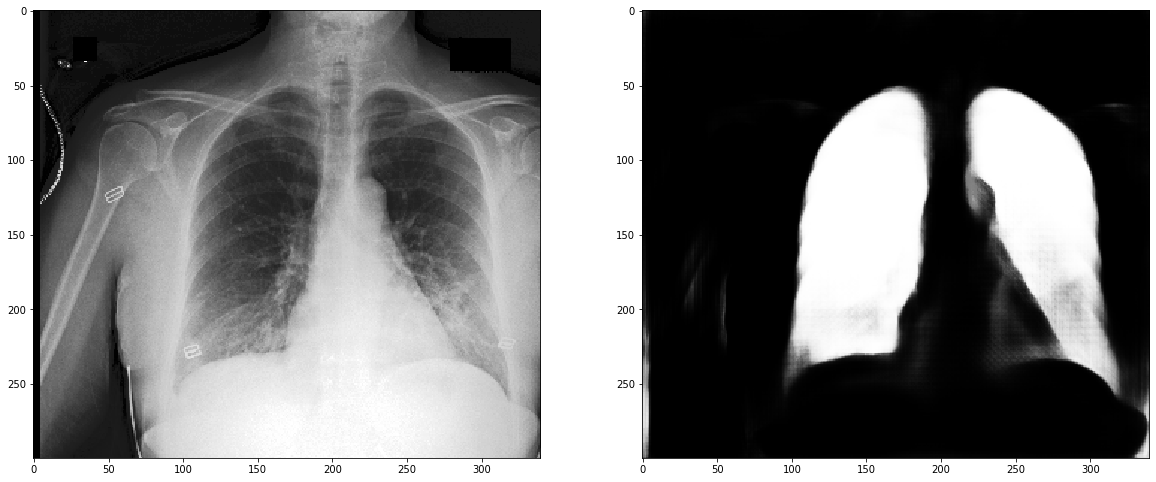

In [8]:
# In[6]

# ### PLOT CONTINUOUS MASK

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

ax = fig.add_subplot(1, 2, 1)

ax.imshow(np.squeeze(input_img), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(mask_float[:,:]), cmap="gray")    


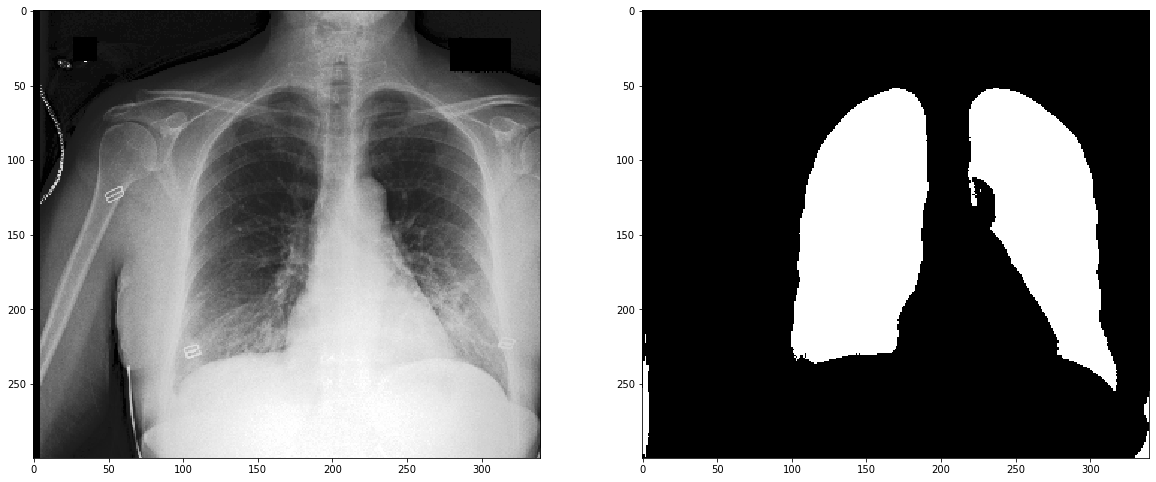

In [9]:
# In[7]

# ### PLOT BINARY MASK

fig = plt.figure(figsize=(20,10))
fig.subplots_adjust(hspace=0.4, wspace=0.2)

ax = fig.add_subplot(1, 2, 1)

ax.imshow(np.squeeze(input_img), cmap="gray")
ax = fig.add_subplot(1, 2, 2)
ax.imshow(np.squeeze(mask_binary[:,:]), cmap="gray")    


In [10]:
# PREDICTION and HEAT MAP

In [28]:
# In[8]:

from MODULES_2.Generators import get_generator, DataGenerator
from MODULES_2.Networks import WaveletScatteringTransform, ResNet 
from MODULES_2.Networks import SelectChannel, TransposeChannel, ScaleByInput, Threshold 
from MODULES_2.Losses import other_metrics_binary_class
from MODULES_2.Constants import _Params, _Paths
from MODULES_2.Utils import get_class_threshold, standardize, commonelem_set
from MODULES_2.Utils import _HEAT_MAP_DIFF
from MODULES_2.Utils import get_roc_curve, compute_gradcam, get_roc_curve_sequence, plot_confusion_matrix
from MODULES_2.Utils import get_mean_roc_curve_sequence, get_multi_roc_curve_sequence

from tensorflow.keras.layers import Input, Average, Lambda, Multiply, Add, GlobalAveragePooling2D, Activation
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model
from tensorflow.compat.v1.logging import INFO, set_verbosity

# load_ext autoreload
%reload_ext autoreload
%autoreload 2


In [12]:
# In[9]:

# ### READ NEW PATIENT DATA
new_patient_df = pd.read_csv("new_patient.csv",index_col = 0)

n_new_patient = len(new_patient_df)
print(n_new_patient)

# name_df = new_patient_df[new_patient_df['Image'].str.contains(name)]
# name_df.to_csv('new_patient.csv', encoding='utf-8', header='true', index=True)


1


In [13]:
# In[10]:

# ### RECOVER STANDARDIZATION PARAMETERS FROM MODULE 1

with open('standardization_parameters_V7.json') as json_file:
    standardization_parameters = json.load(json_file) 
    
train_image_mean = standardization_parameters['mean']
train_image_std = standardization_parameters['std']

print(train_image_mean, train_image_std)


124.07157127013421 75.97485671901313


In [15]:
# In[11]:

# ### PREPARE STANDARDIZED IMAGES as H5 FILES

# Source directories for images and masks
IMAGE_DIR = "new_patient_cxr/image_resized_equalized/"
MASK_DIR = "new_patient_cxr/mask_float/"

# Target directory for H5 file containing both images and masks
H5_IMAGE_DIR = "new_patient_cxr/H5/"

print(IMAGE_DIR)
print(H5_IMAGE_DIR)

pwd = os.getcwd()
if not os.path.isdir(H5_IMAGE_DIR):
    os.mkdir(H5_IMAGE_DIR)

    
# Loop over the set of images to predict

for i in range(n_new_patient):
    print(f'{i},index={new_patient_df.index[i]}')
    valid_image_name, valid_pos_label, valid_neg_label, valid_weight = \
    new_patient_df.iloc[i]['Image'],\
    new_patient_df.iloc[i]['Positive'],\
    new_patient_df.iloc[i]['Negative'],\
    new_patient_df.iloc[i]['ClassWeight']

    valid_image = cv2.imread(IMAGE_DIR + valid_image_name, cv2.IMREAD_GRAYSCALE)
    
# Resize or equalize if this was not already done during datasets preparation    
    # valid_image = cv2.resize(valid_image, (WIDTH, HEIGHT), cv2.INTER_LINEAR)
    # valid_image = cv2.equalizeHist(valid_image)

    valid_image = np.expand_dims(valid_image,axis=-1)
        
    # External learned mask of segmented lungs
    valid_learned_mask = cv2.imread(MASK_DIR + valid_image_name, cv2.IMREAD_GRAYSCALE).astype('float64')
    valid_learned_mask /= 255
    valid_learned_mask = np.expand_dims(valid_learned_mask,axis=-1)
    
    # Internal thresholded mask    
    low_ind = valid_image < 6
    high_ind = valid_image > 225    
    valid_thresholded_mask = np.ones_like(valid_image)
    valid_thresholded_mask[low_ind] = 0
    valid_thresholded_mask[high_ind] = 0

    # Combine the two masks
    valid_mask = np.multiply(valid_thresholded_mask,valid_learned_mask)
    
    # Standardization with training mean and std 
    valid_image = valid_image.astype(np.float64)
    valid_image -= train_image_mean
    valid_image /= train_image_std        
    
    with h5py.File(H5_IMAGE_DIR + valid_image_name[:-4] + '.h5', 'w') as hf: 
        # Images
        Xset = hf.create_dataset(
            name='X',
            data=valid_image,
            shape=(HEIGHT, WIDTH, 1),
            maxshape=(HEIGHT, WIDTH, 1),
            compression="gzip",
            compression_opts=9)
        
        # Masks
        Mset = hf.create_dataset(
            name='M',
            data=valid_mask,
            shape=(HEIGHT, WIDTH, 1),
            maxshape=(HEIGHT, WIDTH, 1),
            compression="gzip",
            compression_opts=9)
        
        # Labels
        yset = hf.create_dataset(
            name='y',
            data=[valid_pos_label,valid_neg_label])
        
        # Class weights
        wset = hf.create_dataset(
            name='w',
            data=valid_weight)             


new_patient_cxr/image_resized_equalized/
new_patient_cxr/H5/
0,index=791


In [16]:
# In[12]:

# ### Generate json dictionary for the new patient names

new_patient_h5_name_list = []

for i in range(n_new_patient):
    # print(f'{i},index={new_patient_df.index[i]}')
    new_patient_image_name = new_patient_df.iloc[i]['Image']
    new_patient_h5_name_list.append(valid_image_name[:-4] + '.h5') 

new_patient_h5_dict = {"new_patient":new_patient_h5_name_list}

# data set
with open(H5_IMAGE_DIR + 'new_patient_dataset.json', 'w') as filehandle:
    json.dump(new_patient_h5_dict, filehandle)     

print(new_patient_h5_dict["new_patient"])


['002130-004-1.h5']


In [ ]:
# In[13]:

# ### DEVICES

# physical_devices_GPU = tf.config.list_physical_devices('GPU') 
# print("Num GPUs:", len(physical_devices_GPU))

# physical_devices_CPU = tf.config.list_physical_devices('CPU') 
# print("Num CPUs:", len(physical_devices_CPU)) 

# local_device_protos = device_lib.list_local_devices()
# print(local_device_protos)

In [17]:
# In[14]:

# ### MODEL AND RUN SELECTION
HEIGHT, WIDTH, CHANNELS, IMG_COLOR_MODE, MSK_COLOR_MODE, NUM_CLASS, \
    KS1, KS2, KS3, DL1, DL2, DL3, NF, NFL, NR1, NR2, DIL_MODE, W_MODE, LS, \
    SHIFT_LIMIT, SCALE_LIMIT, ROTATE_LIMIT, ASPECT_LIMIT, U_AUG, \
    TRAIN_SIZE, VAL_SIZE, DR1, DR2, CLASSES, IMG_CLASS, MSK_FLOAT, MSK_THRESHOLD, \
    MRA, MRALEVEL, MRACHANNELS, WAVELET, WAVEMODE, WST, WST_J, WST_L, WST_FIRST_IMG, \
    SCALE_BY_INPUT, SCALE_THRESHOLD = _Params() 
    
TRAIN_IMG_PATH, TRAIN_MSK_PATH, TRAIN_MSK_CLASS, VAL_IMG_PATH, \
        VAL_MSK_PATH, VAL_MSK_CLASS = _Paths()

In [18]:
# In[15]:

# ### Additional or modified network or fit parameters

NEW_RUN = False
NEW_MODEL_NUMBER = False

UPSAMPLE = False
UPSAMPLE_KERNEL = (2,2)

KS1=(3, 3)
KS2=(3, 3)
KS3=(3, 3)

WSTCHANNELS = 50

RESNET_DIM_1 = 75
RESNET_DIM_2 = 85

SCALE_BY_INPUT = False
SCALE_THRESHOLD = 0.6
SCALE_TO_SPAN = False
SPAN = 1.0

ATT = 'mh'
HEAD_SIZE = 64
NUM_HEAD = 2 
VALUE_ATT = True

BLUR_ATT = False
BLUR_ATT_STD = 0.1
BLUR_SBI = False
BLUR_SBI_STD = 0.1

NR1 = 2

PREP = True
STEM = True

KFOLD = 'Simple' # 'Simple','Strati','Group'

VAL_SIZE = 15

OPTIMIZER = Adam(learning_rate=0.002,
                beta_1=0.9,
                beta_2=0.999,
                epsilon=1e-07,
                amsgrad=True)


In [19]:
# In[16]:

model_selection = 'model_' + str(NF) + 'F_' + str(NR1) + 'R1_' + str(NR2) + 'R2'

if NEW_MODEL_NUMBER:
    model_number = str(datetime.datetime.now())[0:10] + '_' + \
                   str(datetime.datetime.now())[11:13] + '_' + \
                   str(datetime.datetime.now())[14:16]
else:
    model_number = '2021-02-16_11_28'

In [20]:
print(f"\n HEIGHT={HEIGHT}\n WIDTH={WIDTH}\n CHANNELS={CHANNELS}\n NUM_CLASS={NUM_CLASS}") 
print(f"\n KS1={KS1}\n KS2={KS2}\n KS3={KS3}\n DL1={DL1}\n DL2={DL2}\n DL3={DL3}\n NR1={NR1}\n NF={NF}")
print(f"\n OPT_LR={K.eval(OPTIMIZER.lr)}\n OPT_B1={K.eval(OPTIMIZER.beta_1)}\n OPT_B2={K.eval(OPTIMIZER.beta_2)}")
print(f" OPT_EPS={K.eval(OPTIMIZER.epsilon)}\n OPT_AMS={K.eval(OPTIMIZER.amsgrad)}")
print(f"\n PREP={PREP}\n STEM={STEM}")
print(f"\n WST={WST}\n WST_J={WST_J}\n WST_L={WST_L}\n WST_FIRST_IMG={WST_FIRST_IMG}")
print(f"\n RESNET_DIM_1={RESNET_DIM_1}\n RESNET_DIM_2={RESNET_DIM_2}")
print(f"\n MRACHANNELS={MRACHANNELS}\n MSK_FLOAT={MSK_FLOAT}\n MSK_THRESHOLD={MSK_THRESHOLD}")
print(f"\n TRAIN_SIZE={TRAIN_SIZE}\n VAL_SIZE={VAL_SIZE}")
print(f"\n SCALE_BY_INPUT={SCALE_BY_INPUT}\n SCALE_THRESHOLD={SCALE_THRESHOLD}")
print(f"\n SCALE_TO_SPAN={SCALE_TO_SPAN}\n SPAN={SPAN}")
print(f"\n ATT={ATT}\n HEAD_SIZE={HEAD_SIZE}\n NUM_HEAD={NUM_HEAD}\n VALUE_ATT={VALUE_ATT}")
print(f"\n BLUR_ATT={BLUR_ATT}\n BLUR_ATT_STD={BLUR_ATT_STD}\n BLUR_SBI={BLUR_SBI}\n BLUR_SBI_STD={BLUR_SBI_STD}")
print(f"\n KFOLD={KFOLD}")
print(f"\n NEW_RUN={NEW_RUN}\n NEW_MODEL_NUMBER={NEW_MODEL_NUMBER}")
print(f"\n MODEL={model_selection}\n MODEL_NUMBER={model_number}")


 HEIGHT=300
 WIDTH=340
 CHANNELS=1
 NUM_CLASS=2

 KS1=(3, 3)
 KS2=(3, 3)
 KS3=(3, 3)
 DL1=(1, 1)
 DL2=(2, 2)
 DL3=(3, 3)
 NR1=2
 NF=17

 OPT_LR=0.0020000000949949026
 OPT_B1=0.8999999761581421
 OPT_B2=0.9990000128746033
 OPT_EPS=1e-07
 OPT_AMS=True

 PREP=True
 STEM=True

 WST=True
 WST_J=2
 WST_L=6
 WST_FIRST_IMG=True

 RESNET_DIM_1=75
 RESNET_DIM_2=85

 MRACHANNELS=1
 MSK_FLOAT=False
 MSK_THRESHOLD=0.3

 TRAIN_SIZE=15
 VAL_SIZE=15

 SCALE_BY_INPUT=False
 SCALE_THRESHOLD=0.6

 SCALE_TO_SPAN=False
 SPAN=1.0

 ATT=mh
 HEAD_SIZE=64
 NUM_HEAD=2
 VALUE_ATT=True

 BLUR_ATT=False
 BLUR_ATT_STD=0.1
 BLUR_SBI=False
 BLUR_SBI_STD=0.1

 KFOLD=Simple

 NEW_RUN=False
 NEW_MODEL_NUMBER=False

 MODEL=model_17F_2R1_0R2
 MODEL_NUMBER=2021-02-16_11_28


In [21]:
# In[17]:

# ### ENSEMBLE MODEL
K.clear_session()

if SCALE_BY_INPUT:
    loi = 'multiply_2'
else:
    loi = 'multiply_1'

strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
  
    # MODELS

    wst_model = WaveletScatteringTransform(input_shape=(HEIGHT, WIDTH, CHANNELS),
                                           upsample=UPSAMPLE,
                                           upsample_kernel=UPSAMPLE_KERNEL)

    resnet_model = ResNet(input_shape_1=(RESNET_DIM_1, RESNET_DIM_2, WSTCHANNELS),
                           input_shape_2=(RESNET_DIM_1, RESNET_DIM_2, 1),
                           num_class=NUM_CLASS,
                           ks1=KS1, ks2=KS2, ks3=KS3, 
                           dl1=DL1, dl2=DL2, dl3=DL3,
                           filters=NF,resblock1=NR1,
                           r_filters=NFL, resblock2=NR2,
                           dil_mode=DIL_MODE, 
                           sp_dropout=DR1,re_dropout=DR2,
                           prep=PREP,
                           stem=STEM,
                           mask_float=MSK_FLOAT,
                           mask_threshold=MSK_THRESHOLD,
                           att=ATT,
                           head_size=HEAD_SIZE,
                           num_heads=NUM_HEAD,
                           value_att=VALUE_ATT,
                           scale_by_input=SCALE_BY_INPUT,
                           scale_threshold=SCALE_THRESHOLD,
                           scale_to_span=SCALE_TO_SPAN,
                           span=SPAN,                          
                           blur_sbi=BLUR_SBI,
                           blur_sbi_std=BLUR_SBI_STD,                                                                 
                           return_seq=True)

    # recover individual resnet models
    resnet_model_0 = clone_model(resnet_model)
    resnet_model_0.load_weights('models/' + model_selection + '_' + model_number + '_M0' + '_resnet_weights.h5')
    
    for layer in resnet_model_0.layers:
        layer.trainable = False                
    resnet_model__0 = Model(inputs=[resnet_model_0.inputs], 
                            outputs=[resnet_model_0.get_layer(loi).output])    

    
    resnet_model_1 = clone_model(resnet_model)
    resnet_model_1.load_weights('models/' + model_selection + '_' + model_number + '_M1' + '_resnet_weights.h5')
    
    for layer in resnet_model_1.layers:
        layer.trainable = False                
    resnet_model__1 = Model(inputs=[resnet_model_1.inputs], 
                            outputs=[resnet_model_1.get_layer(loi).output]) 

    
    resnet_model_2 = clone_model(resnet_model)
    resnet_model_2.load_weights('models/' + model_selection + '_' + model_number + '_M2' + '_resnet_weights.h5')
    
    for layer in resnet_model_2.layers:
        layer.trainable = False                
    resnet_model__2 = Model(inputs=[resnet_model_2.inputs], 
                            outputs=[resnet_model_2.get_layer(loi).output])

    
    resnet_model_3 = clone_model(resnet_model)
    resnet_model_3.load_weights('models/' + model_selection + '_' + model_number + '_M3' + '_resnet_weights.h5')
    
    for layer in resnet_model_3.layers:
        layer.trainable = False                
    resnet_model__3 = Model(inputs=[resnet_model_3.inputs], 
                            outputs=[resnet_model_3.get_layer(loi).output]) 

    
    resnet_model_4 = clone_model(resnet_model)
    resnet_model_4.load_weights('models/' + model_selection + '_' + model_number + '_M4' + '_resnet_weights.h5')
    
    for layer in resnet_model_4.layers:
        layer.trainable = False                
    resnet_model__4 = Model(inputs=[resnet_model_4.inputs], 
                            outputs=[resnet_model_4.get_layer(loi).output])     

    
    resnet_model_5 = clone_model(resnet_model)
    resnet_model_5.load_weights('models/' + model_selection + '_' + model_number + '_M5' + '_resnet_weights.h5')
    
    for layer in resnet_model_5.layers:
        layer.trainable = False                
    resnet_model__5 = Model(inputs=[resnet_model_5.inputs], 
                            outputs=[resnet_model_5.get_layer(loi).output]) 
    

    # GRAPH 1
    
    wst_input_1 = Input(shape=(HEIGHT, WIDTH, CHANNELS))
    wst_input_2 = Input(shape=(HEIGHT, WIDTH, CHANNELS)) 
    
    wst_output_1 = wst_model([wst_input_1,wst_input_2])    
    
    y0 = resnet_model__0(wst_output_1)
    y1 = resnet_model__1(wst_output_1)    
    y2 = resnet_model__2(wst_output_1)
    y3 = resnet_model__3(wst_output_1)
    y4 = resnet_model__4(wst_output_1)
    y5 = resnet_model__5(wst_output_1)    
    
    d3 = Average()([y0,y1,y2,y3,y4,y5])     
    
    d3 = GlobalAveragePooling2D()(d3)
    
    resnet_output = Activation("softmax", name = 'softmax')(d3)     
    

    ensemble_model = Model([wst_input_1,wst_input_2], resnet_output,name='ensemble_wst_resnet')  

    ensemble_model.compile(optimizer=Adam(), 
                  loss=tf.keras.losses.CategoricalCrossentropy(), 
                  metrics=[tf.keras.metrics.CategoricalAccuracy()]) 

print(wst_model.name + ' model selected')
print(ensemble_model.name + ' model selected')    


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f3911db7c20>. It was defined on this line: backend.fft = FFT(lambda x: tf.signal.fft2d(x, name='fft2d'),
                  lambda x: tf.signal.ifft2d(x, name='ifft2d'),
                  lambda x: tf.math.real(tf.signal.ifft2d(x, name='irfft2d')),
                  lambda x: None)
, which must contain a single lambda with matching signature. To avoid ambiguity, define each lambda in a separate expression.
Cause: Unable to identify source code of lambda function <function <lambda> at 0x7f3911db7c20>. It was defined on this line: backend.fft = FFT(lambda x: tf.signal.fft2d(x, name='fft2d'),
                  lambda x: tf.signal.ifft2d(x, name='ifft2d'),
                  lambda x: tf.math.real(tf.signal.ifft2d(x, name='irfft2d')),
                  lambda x: No

In [22]:
ensemble_model.summary()

Model: "ensemble_wst_resnet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            [(None, 300, 340, 1) 0                                            
__________________________________________________________________________________________________
WST (Model)                     (None, 75, 85, 50)   0           input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model (Model)                   (None, 75, 85, 2)    20467       WST[1][0]      

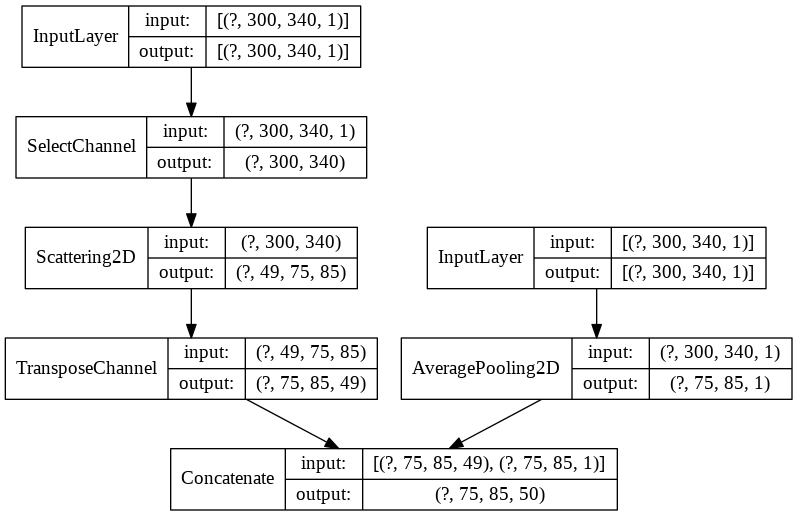

In [31]:
plot_model(wst_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_wst_architecture.png') 

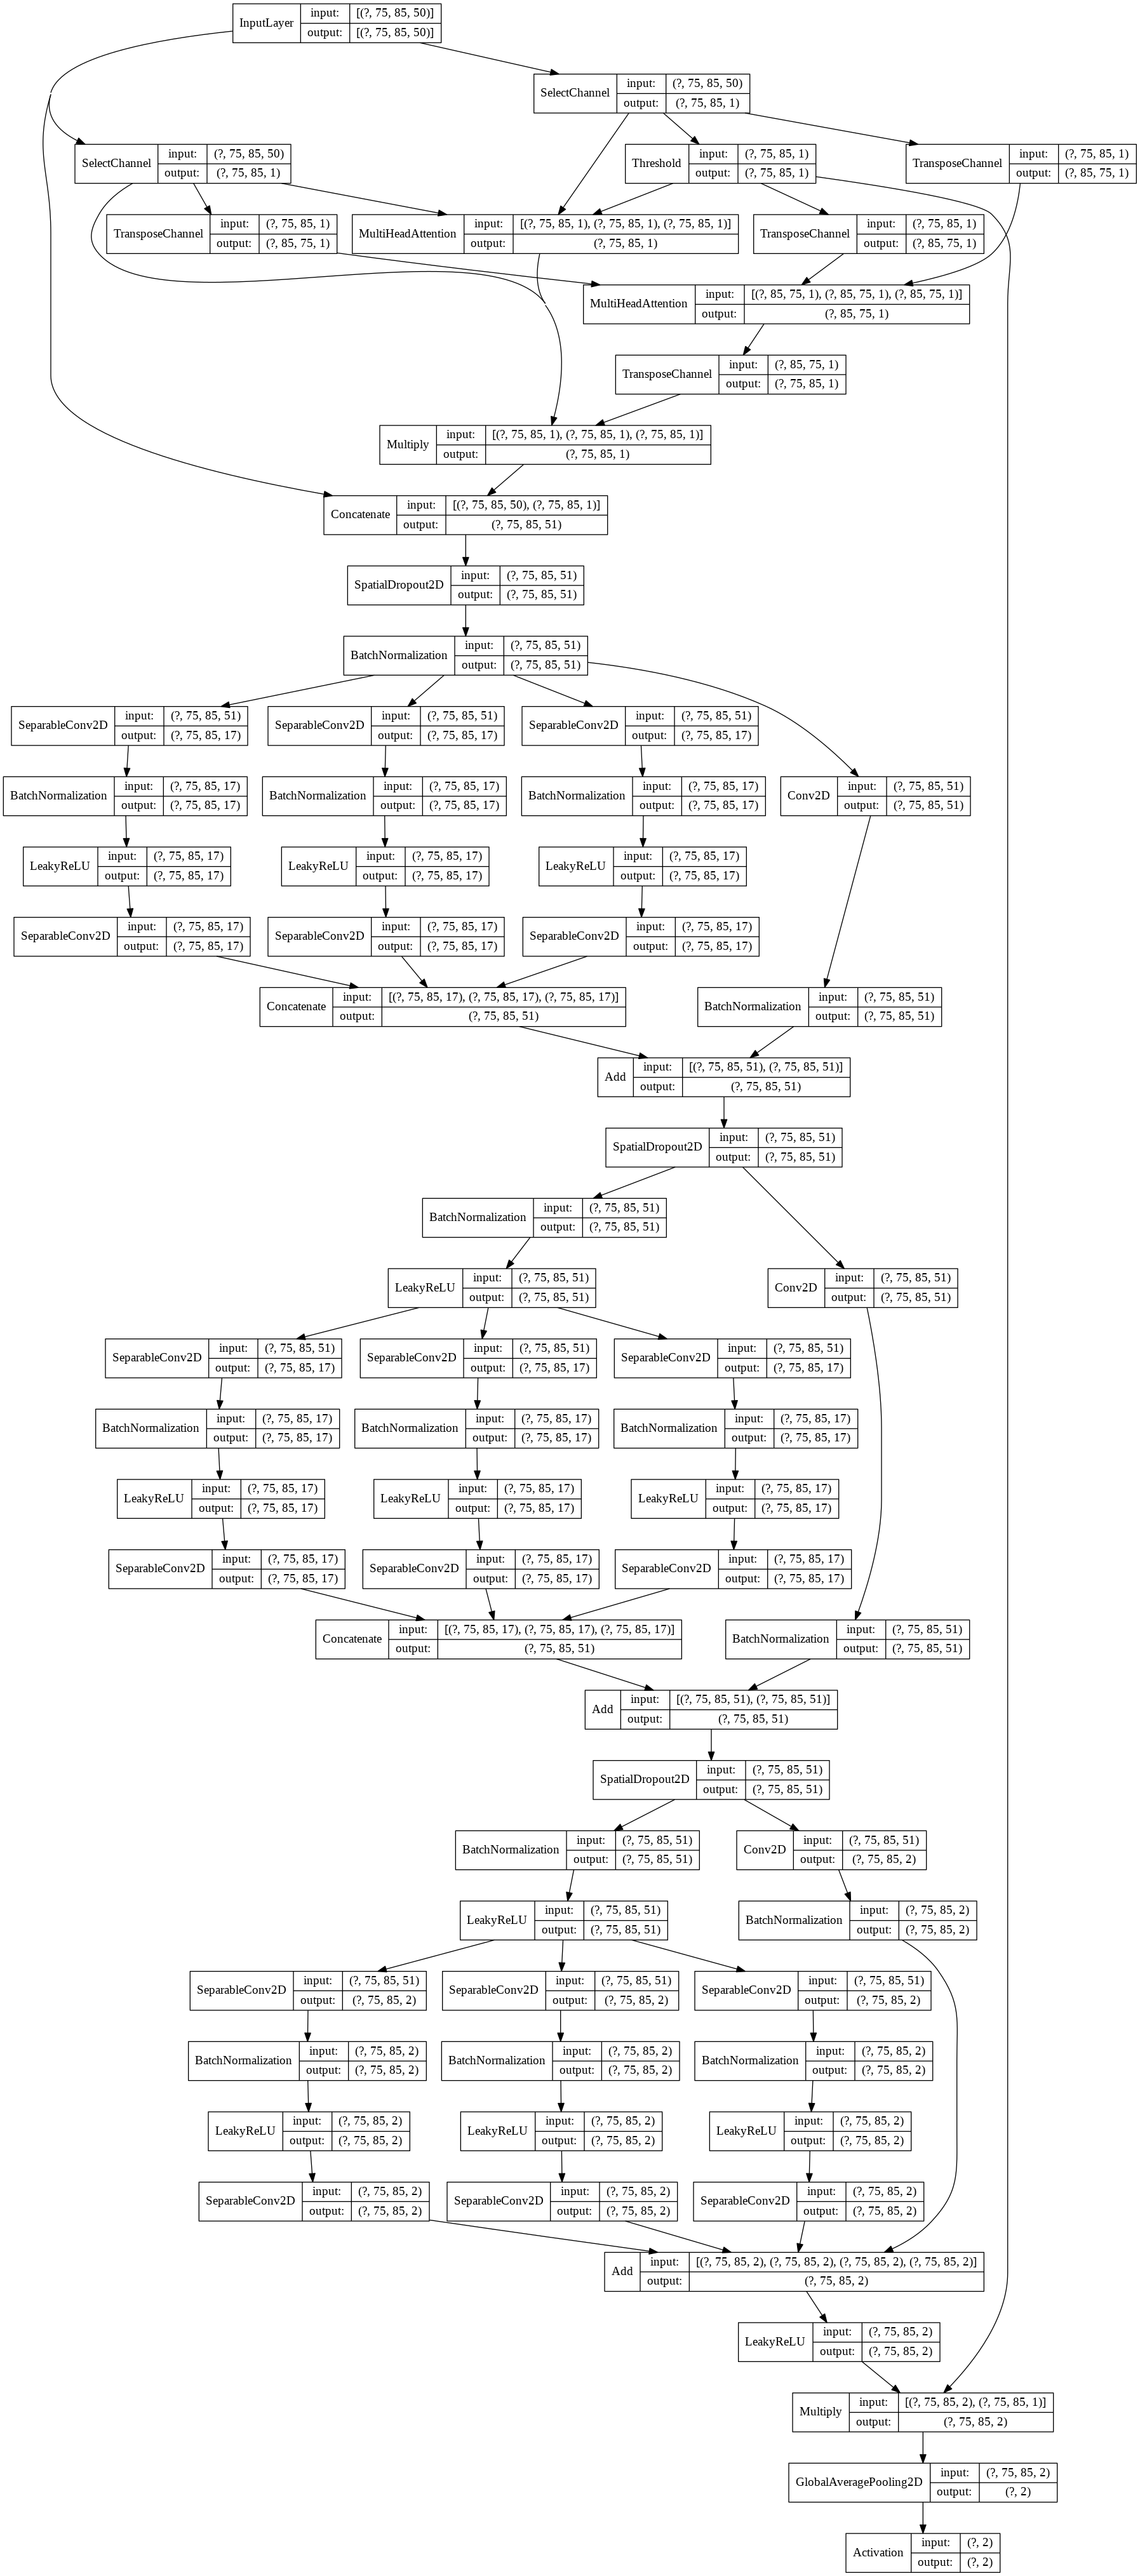

In [32]:
plot_model(resnet_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_resnet_architecture.png')

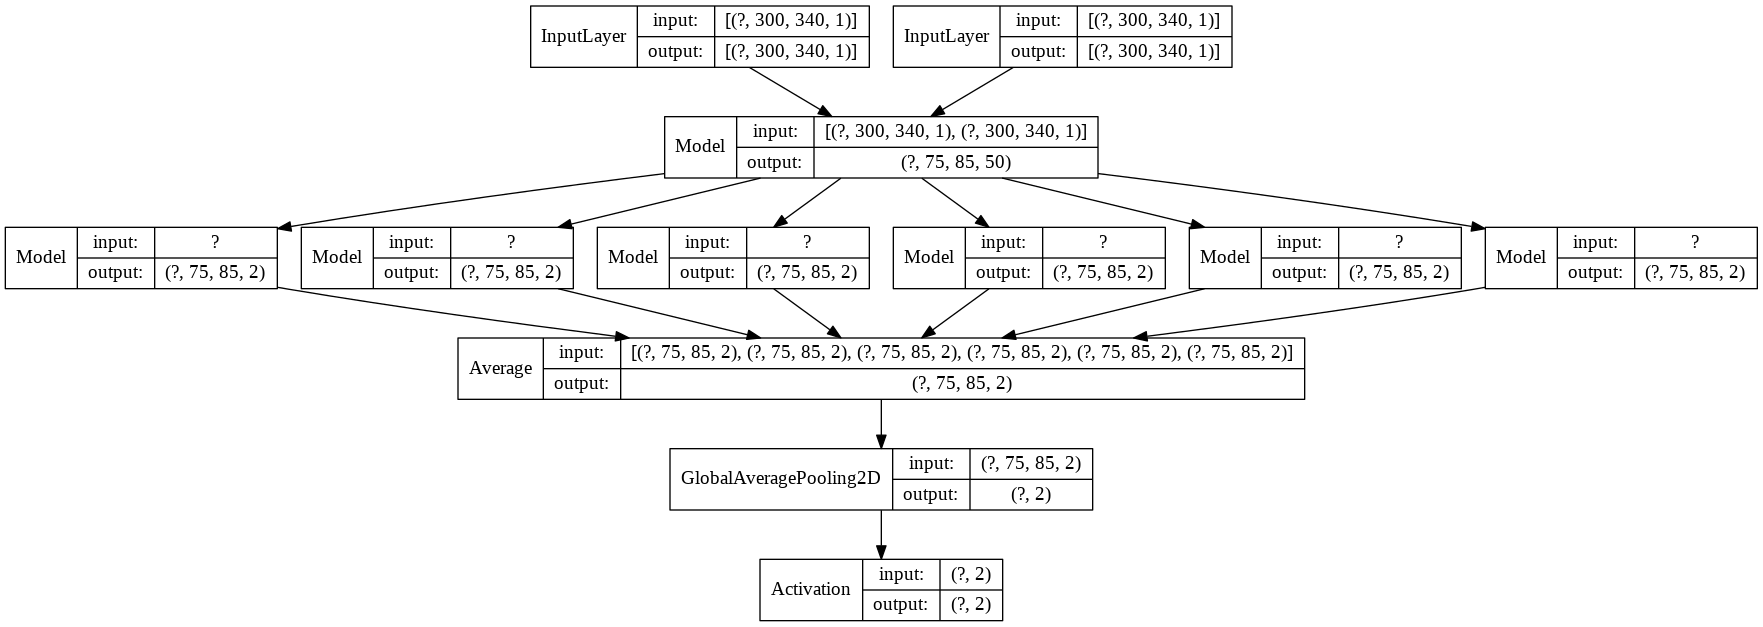

In [30]:
plot_model(ensemble_model, show_shapes=True,\
           show_layer_names=False,\
           to_file='saved_images/' + model_selection + '_' + model_number + '_ensemble_wst_resnet_architecture.png')


In [33]:
# In[18]:

# ### GENERATOR for 1 IMAGE at a time

datadir = H5_IMAGE_DIR

dataset = new_patient_h5_dict
                                      
valid_1_generator = DataGenerator(dataset["new_patient"], datadir, augment=False, shuffle=False, standard=False,\
                                      batch_size=1, dim=(HEIGHT, WIDTH, MRACHANNELS), mask_dim=(HEIGHT, WIDTH, 1), \
                                      mlDWT=False, mralevel=MRALEVEL, wave=WAVELET, wavemode=WAVEMODE, verbose=0)


In [34]:
# In[19]:

# ### PREDICT

valid_y_true = []
valid_y_pred = []

for i in range(len(dataset["new_patient"])):
    x_m, y, w = valid_1_generator.__getitem__(i)
    valid_y_true.append(y[0].tolist())
    y_pred = ensemble_model(x_m).numpy().tolist()
    valid_y_pred.append(y_pred[0])
    
valid_y_true = np.array(valid_y_true)
valid_y_pred = np.array(valid_y_pred)

In [35]:
print(valid_y_true,valid_y_pred)

[[1. 0.]] [[0.93870723 0.06129271]]


In [36]:
valid_pos_list = np.array(dataset["new_patient"])[valid_y_true[:,0]==1].tolist()
valid_neg_list = np.array(dataset["new_patient"])[valid_y_true[:,1]==1].tolist()
new_patient_list = np.array(dataset["new_patient"]).tolist()
print(new_patient_list,valid_pos_list,valid_neg_list)

['002130-004-1.h5'] ['002130-004-1.h5'] []


new_patient_cxr/H5/
/wsu/home/aa/aa14/aa1426/Documents/JENA/MYOTUBES_SEGMENTATION/CXR-Net/run_CXR-Net/new_patient_gradcam_WST_RESNET/
Labels: ['Positive score', 'Negative score'], Image directory: new_patient_cxr/H5/
Image 002130-004-1.h5


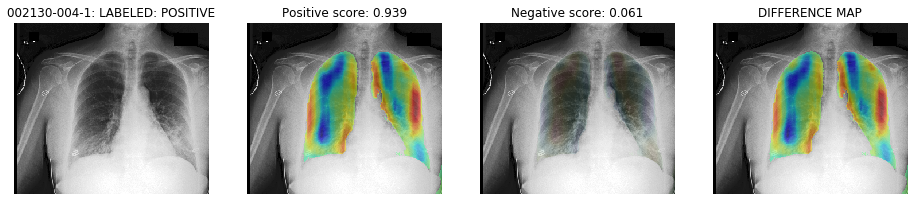

In [37]:
# In[20]:

# ### HEAT MAPS
pwd = os.getcwd()
os.system('mkdir new_patient_gradcam_WST_RESNET')
gradcam_path = os.path.join(pwd,'new_patient_gradcam_WST_RESNET/')
# os.system('mkdir large_set_gradcam_valid_WST_RESNET/negative')
# OUT_IMAGE_DIR = os.path.join(gradcam_path,'negative/')
OUT_IMAGE_DIR = gradcam_path
print(H5_IMAGE_DIR)
print(OUT_IMAGE_DIR)

if valid_y_true[:,0]==1:
    LABEL = "POSITIVE"
else:
    LABEL = "NEGATIVE"

FIG_SIZE = (16,20)

_HEAT_MAP_DIFF(ensemble_model,generator=valid_1_generator,layer='average',\
          labels=['Positive score','Negative score'],header='LABELED: ' + LABEL,figsize=FIG_SIZE,\
          image_dir=H5_IMAGE_DIR,out_image_dir=OUT_IMAGE_DIR,\
          img_list=new_patient_list,first_img=0,last_img=len(new_patient_list),\
          img_width=WIDTH,img_height=HEIGHT,display=True)
